In [1]:
import gc
import io
from collections import namedtuple
from typing import Tuple

import gradio as gr
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from gradio.inputs import Image as GradioInputImage
from gradio.outputs import Image as GradioOutputImage
from matplotlib.pyplot import get_cmap
from PIL import Image
from scipy.sparse.linalg import eigsh
from torch.utils.hooks import RemovableHandle
from torchvision import transforms
from torchvision.utils import make_grid

In [18]:
def get_model(name: str):
    if "dino" in name:
        model = torch.hub.load("facebookresearch/dino:main", name)
        model.fc = torch.nn.Identity()
        val_transform = get_transform(name)
        patch_size = model.patch_embed.patch_size
        num_heads = model.blocks[0].attn.num_heads
    elif name in ["mocov3_vits16", "mocov3_vitb16"]:
        model = torch.hub.load("facebookresearch/dino:main", name.replace("mocov3", "dino"))
        checkpoint_file, size_char = {
            "mocov3_vits16": ("vit-s-300ep-timm-format.pth", "s"),
            "mocov3_vitb16": ("vit-b-300ep-timm-format.pth", "b"),
        }[name]
        url = f"https://dl.fbaipublicfiles.com/moco-v3/vit-{size_char}-300ep/vit-{size_char}-300ep.pth.tar"
        checkpoint = torch.hub.load_state_dict_from_url(url)
        model.load_state_dict(checkpoint["model"])
        model.fc = torch.nn.Identity()
        val_transform = get_transform(name)
        patch_size = model.patch_embed.patch_size
        num_heads = model.blocks[0].attn.num_heads
    else:
        raise ValueError(f"Unsupported model: {name}")
    model = model.eval()
    return model, val_transform, patch_size, num_heads


def get_transform(name: str):
    if any(
        x in name
        for x in (
            "dino",
            "mocov3",
            "convnext",
        )
    ):
        normalize = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        transform = transforms.Compose(
            [
                transforms.Resize(size=(512, 512), interpolation=TF.InterpolationMode.BICUBIC),
                transforms.ToTensor(),
                normalize,
            ]
        )
    else:
        raise NotImplementedError()
    return transform


def get_diagonal(W: scipy.sparse.csr_matrix, threshold: float = 1e-12):
    D = W.dot(np.ones(W.shape[1], W.dtype))
    D[D < threshold] = 1.0  # Prevent division by zero.
    D = scipy.sparse.diags(D)
    return D

In [19]:
# Cache
torch.cuda.empty_cache()

# Parameters
model_name = "dino_vitb16"  # TODO: Figure out how to make this user-editable
K = 5

# Load model
model, val_transform, patch_size, num_heads = get_model(model_name)

# Add hook
which_block = -1
if "dino" in model_name or "mocov3" in model_name:
    feat_out = {}

    def hook_fn_forward_qkv(module, input, output):
        feat_out["qkv"] = output

    handle: RemovableHandle = (
        model._modules["blocks"][which_block]
        ._modules["attn"]
        ._modules["qkv"]
        .register_forward_hook(hook_fn_forward_qkv)
    )
else:
    raise ValueError(model_name)


# GPU
if torch.cuda.is_available():
    print("CUDA is available, using GPU.")
    device = torch.device("cuda")
    model.to(device)
else:
    print("CUDA is not available, using CPU.")
    device = torch.device("cpu")


Using cache found in C:\Users\yitao/.cache\torch\hub\facebookresearch_dino_main


CUDA is available, using GPU.


In [21]:
@torch.no_grad()
def segment(inp: Image):
    # NOTE: The image is already resized to the desired size.

    # Preprocess image
    images: torch.Tensor = val_transform(inp)
    images = images.unsqueeze(0).to(device)

    # Reshape image
    P = patch_size
    B, C, H, W = images.shape
    H_patch, W_patch = H // P, W // P
    H_pad, W_pad = H_patch * P, W_patch * P
    T = H_patch * W_patch + 1  # number of tokens, add 1 for [CLS]

    # Crop image to be a multiple of the patch size
    images = images[:, :, :H_pad, :W_pad]

    # Extract features
    if "dino" in model_name or "mocov3" in model_name:
        model.get_intermediate_layers(images)[0].squeeze(0)
        output_qkv = (
            feat_out["qkv"]
            .reshape(B, T, 3, num_heads, -1 // num_heads)
            .permute(2, 0, 3, 1, 4)
        )
        feats = output_qkv[1].transpose(1, 2).reshape(B, T, -1)[:, 1:, :].squeeze(0)
    else:
        raise ValueError(model_name)

    # Normalize features
    normalize = True
    if normalize:
        feats = F.normalize(feats, p=2, dim=-1)

    # Compute affinity matrix
    W_feat = feats @ feats.T

    # Feature affinities
    threshold_at_zero = True
    if threshold_at_zero:
        W_feat = W_feat * (W_feat > 0)
    W_feat = (
        W_feat / W_feat.max()
    )  # NOTE: If features are normalized, this naturally does nothing
    W_feat = W_feat.cpu().numpy()

    # # NOTE: Here is where we would add the color information. For simplicity, we will not add it here.
    # W_comb = W_feat + W_color * image_color_lambda  # combination
    # D_comb = np.array(get_diagonal(W_comb).todense())  # is dense or sparse faster? not sure, should check

    # Diagonal
    W_comb = W_feat
    D_comb = np.array(
        get_diagonal(W_comb).todense()
    )  # is dense or sparse faster? not sure, should check

    # Compute eigenvectors
    try:
        eigenvalues, eigenvectors = eigsh(
            D_comb - W_comb, k=(K + 1), sigma=0, which="LM", M=D_comb
        )
    except:
        eigenvalues, eigenvectors = eigsh(
            D_comb - W_comb, k=(K + 1), which="SM", M=D_comb
        )
    eigenvalues = torch.from_numpy(eigenvalues)
    eigenvectors = torch.from_numpy(eigenvectors.T).float()

    # Resolve sign ambiguity
    for k in range(eigenvectors.shape[0]):
        if (
            0.5 < torch.mean((eigenvectors[k] > 0).float()).item() < 1.0
        ):  # reverse segment
            eigenvectors[k] = 0 - eigenvectors[k]

    # Arrange eigenvectors into grid
    # cmap = get_cmap('viridis')
    output_images = []
    # eigenvectors_upscaled = []
    for i in range(1, K + 1):
        eigenvector = eigenvectors[i].reshape(
            1, 1, H_patch, W_patch
        )  # .reshape(1, 1, H_pad, W_pad)
        eigenvector: torch.Tensor = F.interpolate(
            eigenvector, size=(H_pad, W_pad), mode="bilinear", align_corners=False
        )  # slightly off, but for visualizations this is okay
        buffer = io.BytesIO()
        plt.imsave(
            buffer, eigenvector.squeeze().numpy(), format="png"
        )  # save to a temporary location
        buffer.seek(0)
        eigenvector_vis = Image.open(buffer).convert("RGB")
        # eigenvector_vis = TF.to_tensor(eigenvector_vis).unsqueeze(0)
        eigenvector_vis = np.array(eigenvector_vis)
        # eigenvectors_upscaled.append(eigenvector)
        output_images.append(eigenvector_vis)
    # output_images = torch.cat(output_images, dim=0)
    # output_images = make_grid(output_images, nrow=8, pad_value=1)

    # Also add CRF
    if False:
        # Imports
        import denseCRF

        # Parameters
        ParamsCRF = namedtuple("ParamsCRF", "w1 alpha beta w2 gamma it")
        DEFAULT_CRF_PARAMS = ParamsCRF(
            w1=6,  # weight of bilateral term  # 10.0,
            alpha=40,  # spatial std  # 80,
            beta=13,  # rgb  std  # 13,
            w2=3,  # weight of spatial term  # 3.0,
            gamma=3,  # spatial std  # 3,
            it=5.0,  # iteration  # 5.0,
        )

        # Get unary potentials
        unary_potentials = eigenvectors_upscaled[0].squeeze(1).squeeze(0)
        unary_potentials = (unary_potentials - unary_potentials.min()) / (
            unary_potentials.max() - unary_potentials.min()
        )
        unary_potentials_np = (
            torch.stack((1 - unary_potentials, unary_potentials), dim=-1).cpu().numpy()
        )
        img_np = images.cpu().numpy().transpose(0, 2, 3, 1)
        img_np = (img_np * 255).astype(np.uint8)[0]

        # Return result of CRF
        out = denseCRF.densecrf(img_np, unary_potentials_np, DEFAULT_CRF_PARAMS)
        out = out * 255
        output_images.append(out)

    # # Postprocess for Gradio
    # output_images = np.array(TF.to_pil_image(output_images))
    print(f"{len(output_images)=}")

    # Garbage collection and other memory-related things
    gc.collect()
    del eigenvector, eigenvector_vis, eigenvectors, W_comb, D_comb

    return output_images


In [22]:
input_image = Image.open("./dataset/WildBees/Andrena_flavipes_34350822_1.jpg")

preds = segment(input_image)


len(output_images)=5


In [23]:
preds[0].shape


(512, 512, 3)

[Text(0, -10, 'eigen 0'),
 Text(0, -10, 'eigen 1'),
 Text(0, -10, 'eigen 2'),
 Text(0, -10, 'eigen 3'),
 Text(0, -10, 'eigen 4')]

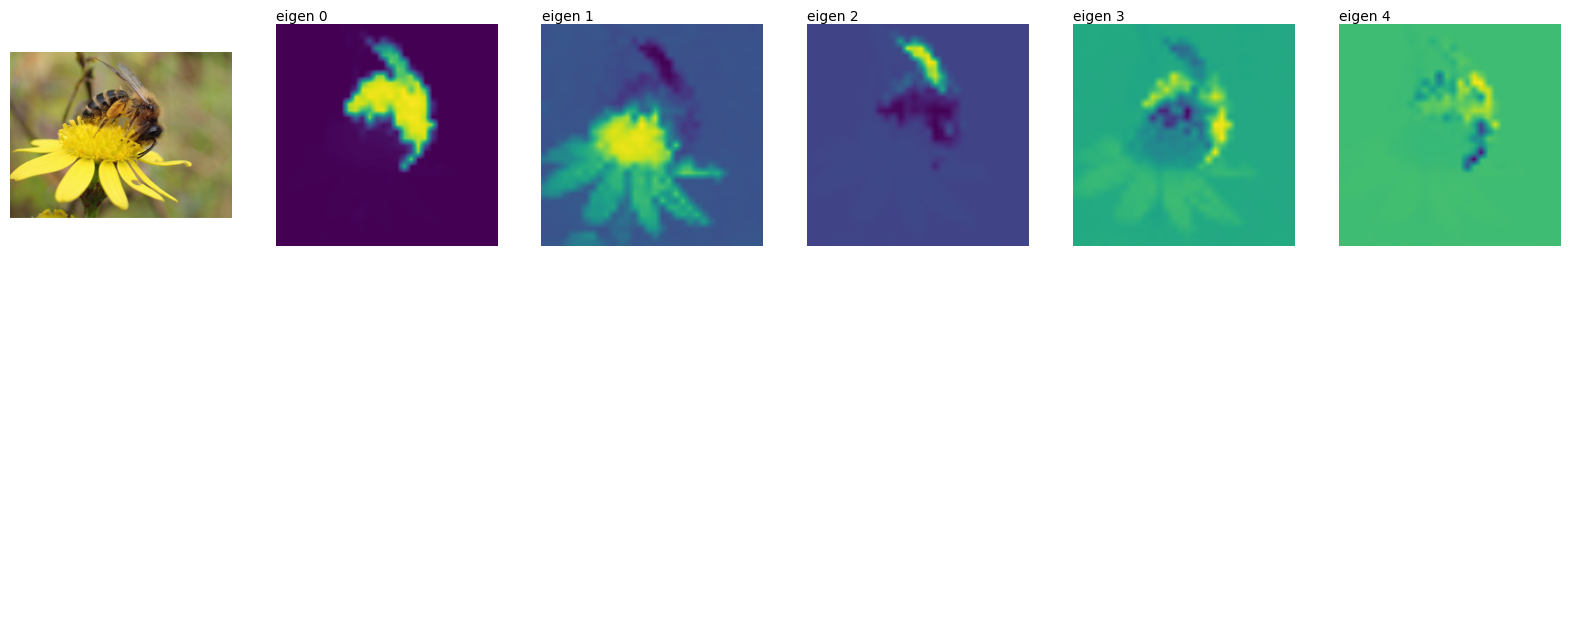

In [24]:
length = len(preds)

_, ax = plt.subplots(2, length + 1, figsize=(20, 8))
[a.axis("off") for a in ax.flatten()]
ax[0][0].imshow(input_image)
[ax[0][i + 1].imshow(preds[i]) for i in range(length)]
[ax[0][i + 1].text(0, -10, "eigen " + str(i)) for i in range(length)]
# [ax[1][i + 1].imshow(preds[i]) for i in range(length)]
